In [167]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import torch
from pytorch_lightning.cli import LightningCLI

from pdearena.data.utils import PDEDataConfig
from pdearena.models.pderefiner import PDERefiner
from pdearena.data.datamodule import PDEDataModule
from pdearena.data.utils import PDEDataConfig
from scripts.pderefiner_train import CondCLI

data_dir = '/media/dan/DATA1/Kuramoto-Sivashinsky-Cond'
checkpoint_file = os.path.abspath('saved_checkpoints/fixed_nu_epoch19.ckpt')
config_file = os.path.abspath('./configs/kuramotosivashinsky1d.yaml')

In [168]:
import sys

# Remove Jupyter-specific arguments
sys.argv = sys.argv[:1]

traj_len = 2048

arguments = ''
arguments += '-c ' + config_file
arguments += ' --data.data_dir ' + data_dir
arguments += ' --data.batch_size ' + str(traj_len)

sys.argv.extend(arguments.split(" "))

cli = CondCLI(
    PDERefiner,
    PDEDataModule,
    run=False,
    parser_kwargs={"parser_mode": "omegaconf"},
)

Global seed set to 42
/home/dan/Desktop/STUDY/ADL4Phys_seminar/.venv/lib/python3.12/site-packages/pytorch_lightning/cli.py:645: UserWarning: `PDERefiner.configure_optimizers` will be overridden by `CondCLI.configure_optimizers`.
  _warn(
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [169]:

checkpoint = torch.load(checkpoint_file)

/tmp/ipykernel_76775/478004083.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


In [170]:
cli.model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [171]:
cli.datamodule.setup()

Loading train data from 1 files.
Loading valid data from 1 files.
Loading valid data from 1 files.
Loading test data from 1 files.
Loading test data from 1 files.


In [172]:
train_dataloader = cli.datamodule.train_dataloader()
val_dataloader = cli.datamodule.val_dataloader()
test_dataloader = cli.datamodule.test_dataloader()

In [174]:
for batch in train_dataloader:
    inputs, targets, cond = batch
    break
# cond = cond[0:1, :]

In [175]:
inputs.shape

torch.Size([2048, 1, 1, 256])

In [176]:
cond.shape

torch.Size([2048, 3])

In [177]:
cond[0:1, :]

tensor([[ 5.4402,  3.7381, 43.4128]])

In [183]:
file_path = '/media/dan/DATA1/Kuramoto-Sivashinsky-Cond/KS_test_conditional_viscosity.h5'

def print_structure(name, obj):
    """Print the structure of the HDF5 file"""
    print(name)

with h5py.File(file_path, 'r') as f:
    f.visititems(print_structure)
    data = f['test/pde_1140-256']
    npdata = np.array(data)
    v = f['test/v']
    cond = np.array(v)
    
len_traj = 200

test
test/dt
test/dx
test/pde_1140-256
test/t
test/v
test/x


In [184]:
cond

array([0.73427048, 1.16050716, 1.01416456, 0.97657995, 0.81351412,
       0.55654542, 0.81004345, 0.67957677, 0.64068451, 0.70207507,
       1.08907192, 1.17099738, 1.24603481, 0.76800216, 1.31431181,
       0.51916911, 0.54495354, 0.98666925, 0.78156627, 1.25087219,
       0.67517939, 1.35710613, 0.5233161 , 1.3727728 , 1.15905428,
       1.32919568, 1.47693885, 1.12611294, 0.85461301, 1.24478635,
       0.64290861, 1.37251596, 1.47770859, 1.1897213 , 0.71489315,
       0.91182046, 1.4833958 , 0.68639575, 0.90668446, 1.05217401,
       1.26180207, 0.77706712, 0.53340977, 1.32211838, 0.72984006,
       0.96557692, 1.15145215, 1.46244576, 0.78503052, 1.17501589,
       0.95193862, 1.05489764, 0.82944595, 1.43103201, 1.13359139,
       0.95579005, 1.14585902, 1.47430386, 1.13622017, 1.21349371,
       1.13609229, 1.00234704, 1.11271274, 1.27644857, 0.7237448 ,
       0.71371867, 0.80767913, 1.08706348, 1.49396883, 1.02881005,
       1.19137493, 0.6818412 , 0.54308159, 0.89016526, 0.78129

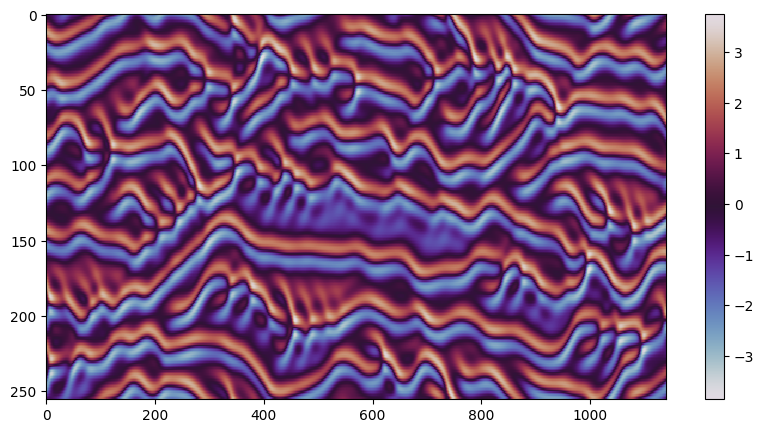

In [181]:
plt.figure(figsize=(10,5))
#set cmap
plt.set_cmap('twilight')
plt.imshow(npdata[0,:,:].T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

In [142]:
initial_condition = npdata[0:1, 0:1, :]
initial_condition = np.expand_dims(initial_condition, axis=0)
initial_condition = torch.tensor(initial_condition, dtype=torch.float32)

In [150]:
cond

tensor([[1.0000e-04, 1.0000e-04]])

In [151]:
prediction_traj = []
cond = cond / max(cond) * 1000


cli.model.eval()
with torch.no_grad():
    u = initial_condition
    for i in range(len_traj):
        prediction = cli.model(u, cond)
        prediction_traj.append(prediction[0].numpy())
        u = prediction
        
prediction_traj = np.array(prediction_traj)

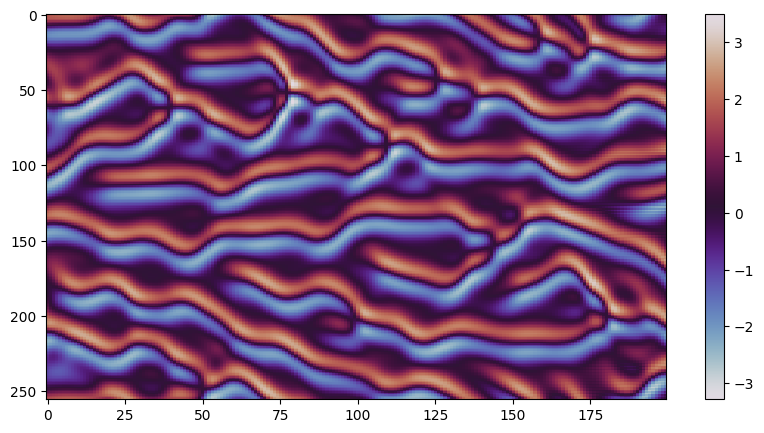

In [152]:
plt.figure(figsize=(10,5))
#set cmap
plt.set_cmap('twilight')
plt.imshow(prediction_traj[:,0, 0,:].T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()